# Driver Analysis
This notebook compares the top 3 drivers in the World Drivers' Championship as of 21 races finished in the 2024 season:
- Max Verstappen (VER): Red Bull Racing
- Lando Norris (NOR): McLaren
- Charles Leclerc (LEC): Ferrari

*This analysis uses data from FastF1 API*

In [4]:
# !pip install fastf1

In [9]:
from core.extract import F1DataProcessor
from core.telemetry import F1TelemetryAnalyzer
from core.dpi import F1DriverPerformanceIndex
from core.utils import plot_combined_analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import fastf1

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Qualifying Performance
We use two datasets here `quali_data` and `quali_telemetry`.
1. `quali_data` contains general information about laps done in qualifying sessions taken from `session.laps` endpoint
2. `quali_telemetry` contains telemetry data about each lap done in qualifying sessions (standardized to have 300 data points per lap) taken from `get_car_data()` endpoint

A Grand Prix qualifying session determines the grid order for Sunday Grand Prix races, and is broken down into three further sessions: Q1, Q2, Q3. Five drivers are knocked out after each Qualifying session, with Q3 being a top-10 shootout for pole position (position 1 on the grid).
<br>
<br>
**quali_data**
- Most of the information in this dataframe is already given by `session.laps` endpoint
- Transformations done: <br>
     (1) Converted `SectorTime` to total seconds<br>
     (2) Added `LapEndDate` to extract accurate corresponding telemetry data<br>
     (3) Added `QualiSession` to determine which qualifying session the lap was set (only fast laps* are considered)<br>
     (4) Added `LapRank` which is the driver's lap's rank at the time of setting it<br>
     (5) Added `DeltaFastestLap` which is the driver's lap's difference from the fastest lap at the time of setting it<br>

**quali_telemetry**
- Most of the information in this dataframe is already given by `get_car_data` endpoint
- Added identifier columns to merge with `quali_data` (`Round`, `Driver`, `LapNumber`)


*Fast laps are considered the driver's best attempt (no warm-up laps or cool down laps)

In [ ]:
# Creates a cache file if not yet existed
cache_dir = './fastf1_cache'
os.makedirs(cache_dir, exist_ok=True)  # creates it if not already existing
fastf1.Cache.enable_cache(cache_dir)

In [12]:
processor = F1DataProcessor(cache_dir='./fastf1_cache', year=2024)

# Get normalized qualifying data
quali_data, quali_telemetry = processor.get_quali_session(
    rounds=range(1, 22),
    drivers=["VER", "NOR", "LEC", "PIA"],
    normalize_telemetry=True, 
    target_points=300
)

_api        WARNING 	Driver 12: Position data is incomplete!
_api        WARNING 	Driver  2: Position data is incomplete!
_api        WARNING 	Driver  3: Position data is incomplete!
_api        WARNING 	Driver  4: Position data is incomplete!
_api        WARNING 	Driver 10: Position data is incomplete!
_api        WARNING 	Driver 11: Position data is incomplete!
_api        WARNING 	Driver 14: Position data is incomplete!
_api        WARNING 	Driver 16: Position data is incomplete!
_api        WARNING 	Driver 18: Position data is incomplete!
_api        WARNING 	Driver 20: Position data is incomplete!
_api        WARNING 	Driver 22: Position data is incomplete!
_api        WARNING 	Driver 23: Position data is incomplete!
_api        WARNING 	Driver 27: Position data is incomplete!
_api        WARNING 	Driver 31: Position data is incomplete!
_api        WARNING 	Driver 44: Position data is incomplete!
_api        WARNING 	Driver 55: Position data is incomplete!
_api        WARNING 	Dri

In [13]:
quali_data

,Round,Driver,DriverNumber,Team,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,...,TrackStatus,Deleted,DeletedReason,LapStartDate,LapEndDate,QualiSession,LapRank,CurrentFastestLap,DeltaFastestLap,Position
18,1,LEC,16,Ferrari,0 days 00:01:31.260000,2.0,1.0,29.522,39.009,22.729,...,1,False,,2024-03-01 16:02:12.510,2024-03-01 16:03:43.770,1.0,2.0,0 days 00:01:31.208000,0.052,2.0
118,1,PIA,81,McLaren,0 days 00:01:30.692000,2.0,1.0,29.243,38.780,22.669,...,1,False,,2024-03-01 16:08:14.593,2024-03-01 16:09:45.285,1.0,2.0,0 days 00:01:30.623000,0.069,8.0
103,1,NOR,4,McLaren,0 days 00:01:30.143000,2.0,1.0,28.983,38.576,22.584,...,1,False,,2024-03-01 16:08:33.263,2024-03-01 16:10:03.406,1.0,1.0,0 days 00:01:30.143000,0.000,7.0
1,1,VER,1,Red Bull Racing,0 days 00:01:30.031000,2.0,1.0,28.787,38.580,22.664,...,1,False,,2024-03-01 16:08:56.653,2024-03-01 16:10:26.684,1.0,1.0,0 days 00:01:30.031000,0.000,1.0
21,1,LEC,16,Ferrari,0 days 00:01:30.243000,5.0,2.0,29.067,38.589,22.587,...,1,False,,2024-03-01 16:09:51.898,2024-03-01 16:11:22.141,1.0,5.0,0 days 00:01:30.031000,0.212,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,21,NOR,4,McLaren,0 days 00:01:24.092000,31.0,8.0,21.414,44.531,18.147,...,1,False,,2024-11-03 12:09:43.228,2024-11-03 12:11:07.320,3.0,1.0,0 days 00:01:24.092000,0.000,1.0
236,21,PIA,81,McLaren,0 days 00:01:26.107000,27.0,7.0,22.488,45.241,18.378,...,1,False,,2024-11-03 12:09:49.072,2024-11-03 12:11:15.179,3.0,14.0,0 days 00:01:24.092000,2.015,8.0
179,21,LEC,16,Ferrari,0 days 00:01:28.755000,27.0,8.0,22.538,46.042,20.175,...,1,False,,2024-11-03 12:09:56.962,2024-11-03 12:11:25.717,3.0,17.0,0 days 00:01:24.092000,4.663,6.0
31,21,NOR,4,McLaren,0 days 00:01:23.405000,32.0,8.0,21.639,43.807,17.959,...,1,False,,2024-11-03 12:11:07.320,2024-11-03 12:12:30.725,3.0,1.0,0 days 00:01:23.405000,0.000,1.0


In [3]:
quali_data.head()

,Round,Driver,DriverNumber,Team,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,...,TrackStatus,Deleted,DeletedReason,LapStartDate,LapEndDate,QualiSession,LapRank,CurrentFastestLap,DeltaFastestLap,Position
18,1,LEC,16,Ferrari,0 days 00:01:31.260000,2.0,1.0,29.522,39.009,22.729,...,1,False,,2024-03-01 16:02:12.510,2024-03-01 16:03:43.770,1.0,2.0,0 days 00:01:31.208000,0.052,2.0
118,1,PIA,81,McLaren,0 days 00:01:30.692000,2.0,1.0,29.243,38.780,22.669,...,1,False,,2024-03-01 16:08:14.593,2024-03-01 16:09:45.285,1.0,2.0,0 days 00:01:30.623000,0.069,8.0
103,1,NOR,4,McLaren,0 days 00:01:30.143000,2.0,1.0,28.983,38.576,22.584,...,1,False,,2024-03-01 16:08:33.263,2024-03-01 16:10:03.406,1.0,1.0,0 days 00:01:30.143000,0.000,7.0
1,1,VER,1,Red Bull Racing,0 days 00:01:30.031000,2.0,1.0,28.787,38.580,22.664,...,1,False,,2024-03-01 16:08:56.653,2024-03-01 16:10:26.684,1.0,1.0,0 days 00:01:30.031000,0.000,1.0
21,1,LEC,16,Ferrari,0 days 00:01:30.243000,5.0,2.0,29.067,38.589,22.587,...,1,False,,2024-03-01 16:09:51.898,2024-03-01 16:11:22.141,1.0,5.0,0 days 00:01:30.031000,0.212,2.0


In [4]:
quali_telemetry.head()

,RPM,Speed,nGear,DRS,Throttle,Brake,CumulativeDistance,Time,LapNumber,Driver,Round
0,10645.000000,297.000000,7.0,12.0,100.0,0.0,0.000000,0 days 00:00:00.107000,1,VER,1
1,10683.277592,299.254181,8.0,12.0,100.0,0.0,17.103010,0 days 00:00:00.292418060,1,VER,1
2,10756.658863,301.508361,8.0,12.0,100.0,0.0,54.351208,0 days 00:00:00.507668896,1,VER,1
3,10809.782609,303.762542,8.0,12.0,100.0,0.0,108.555230,0 days 00:00:00.688384615,1,VER,1
4,10909.478261,306.525084,8.0,12.0,100.0,0.0,188.546469,0 days 00:00:00.970501672,1,VER,1


In [5]:
quali_data.groupby(["Driver", "QualiSession"]).LapRank.mean()

Driver  QualiSession
LEC     1.0             13.741176
        2.0              6.875000
        3.0              4.285714
NOR     1.0             15.591549
        2.0              6.975610
        3.0              3.285714
PIA     1.0             15.520548
        2.0              7.714286
        3.0              4.659091
VER     1.0             16.710145
        2.0              5.340426
        3.0              2.658537
Name: LapRank, dtype: float64

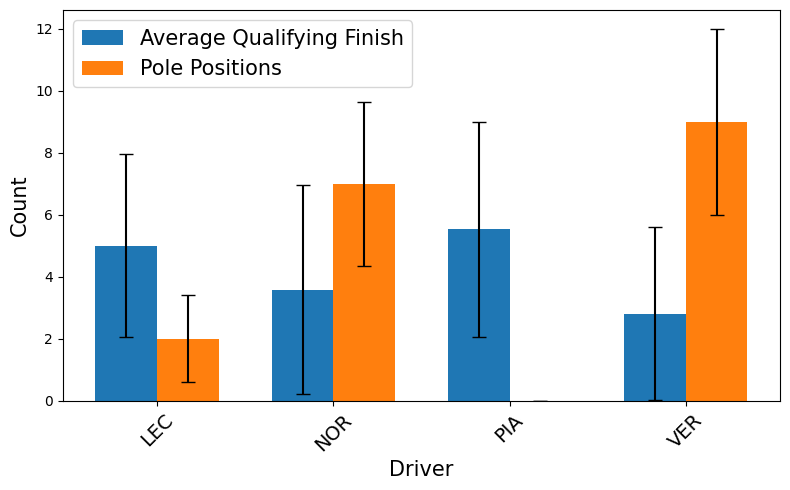

In [6]:
quali_results = quali_data[["Round", "Driver", "Position"]].drop_duplicates()
quali_results = quali_results.groupby(["Driver"]).agg({"Position": [("avg_starting_pos", "mean"), ("std_starting_pos", "std"), ("pole_count", lambda x: (x == 1).sum())]})

plt.figure(figsize=(8, 5))

x = range(len(quali_results.index))
width = 0.35

plt.bar([i - width/2 for i in x], quali_results["Position"]["avg_starting_pos"], width, 
       yerr=quali_results["Position"]["std_starting_pos"], 
       capsize=5,
       label="Average Qualifying Finish")

plt.bar([i + width/2 for i in x], quali_results["Position"]["pole_count"], width,
       yerr=np.sqrt(quali_results["Position"]["pole_count"]),
       capsize=5,
       label="Pole Positions")

plt.xlabel("Driver", fontsize=15)
plt.ylabel("Count", fontsize=15)
# plt.title("2024 Qualifying Performance Comparison", fontsize=15)
plt.xticks(x, quali_results.index, rotation=45, fontsize=14)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig("imgs/2024 Qualifying Performance Comparison.png")
plt.show()

### Telemetry Analysis

In [7]:
analyzer = F1TelemetryAnalyzer(n_samples=300)

results = analyzer.analyze_laps(
   quali_telemetry,
   rounds=range(1, 22),
   drivers=["VER", "NOR", "LEC", "PIA"],
   session_type="Qualifying",
)

processed_laps = results["processed_data"]
lap_metrics = results["lap_metrics"]
distance_matrices = results["distance_matrices"]

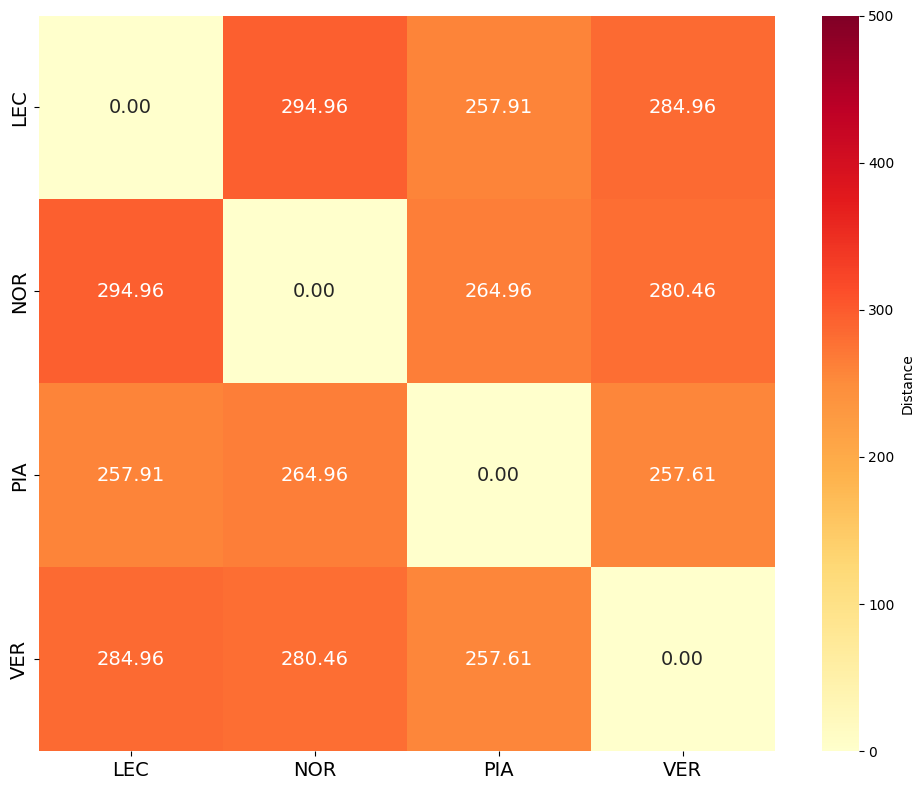

In [8]:
avg_matrix = np.mean(list(distance_matrices.values()), axis=0)

drivers = ["LEC", "NOR", "PIA", "VER"]
df = pd.DataFrame(avg_matrix, index=drivers, columns=drivers)

plt.figure(figsize=(10, 8))
sns.heatmap(df, 
            annot=True, 
            fmt=".2f",
            cmap="YlOrRd",
            square=True,
            annot_kws={'size': 14},
            cbar_kws={"label": "Distance"},
            vmin=0,
            vmax=500)

# plt.title("Average Qualifying Speed Distance Matrix")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("imgs/Average Qualifying Speed Distance Matrix.png")
plt.show()

### Last 5 Quali Comparison
We take the last 5 races of the 2024 season to compare as these races have seen all three drivers win and has been hailed as the races that have had the cars on almost level ground.<br>
The last 5 races are:
- Azerbaijan Grand Prix
- Singapore Grand Prix -> Norris won
- United States Grand Prix -> Leclerc won
- Mexico Grand Prix
- São Paulo Grand Prix -> Verstappen won

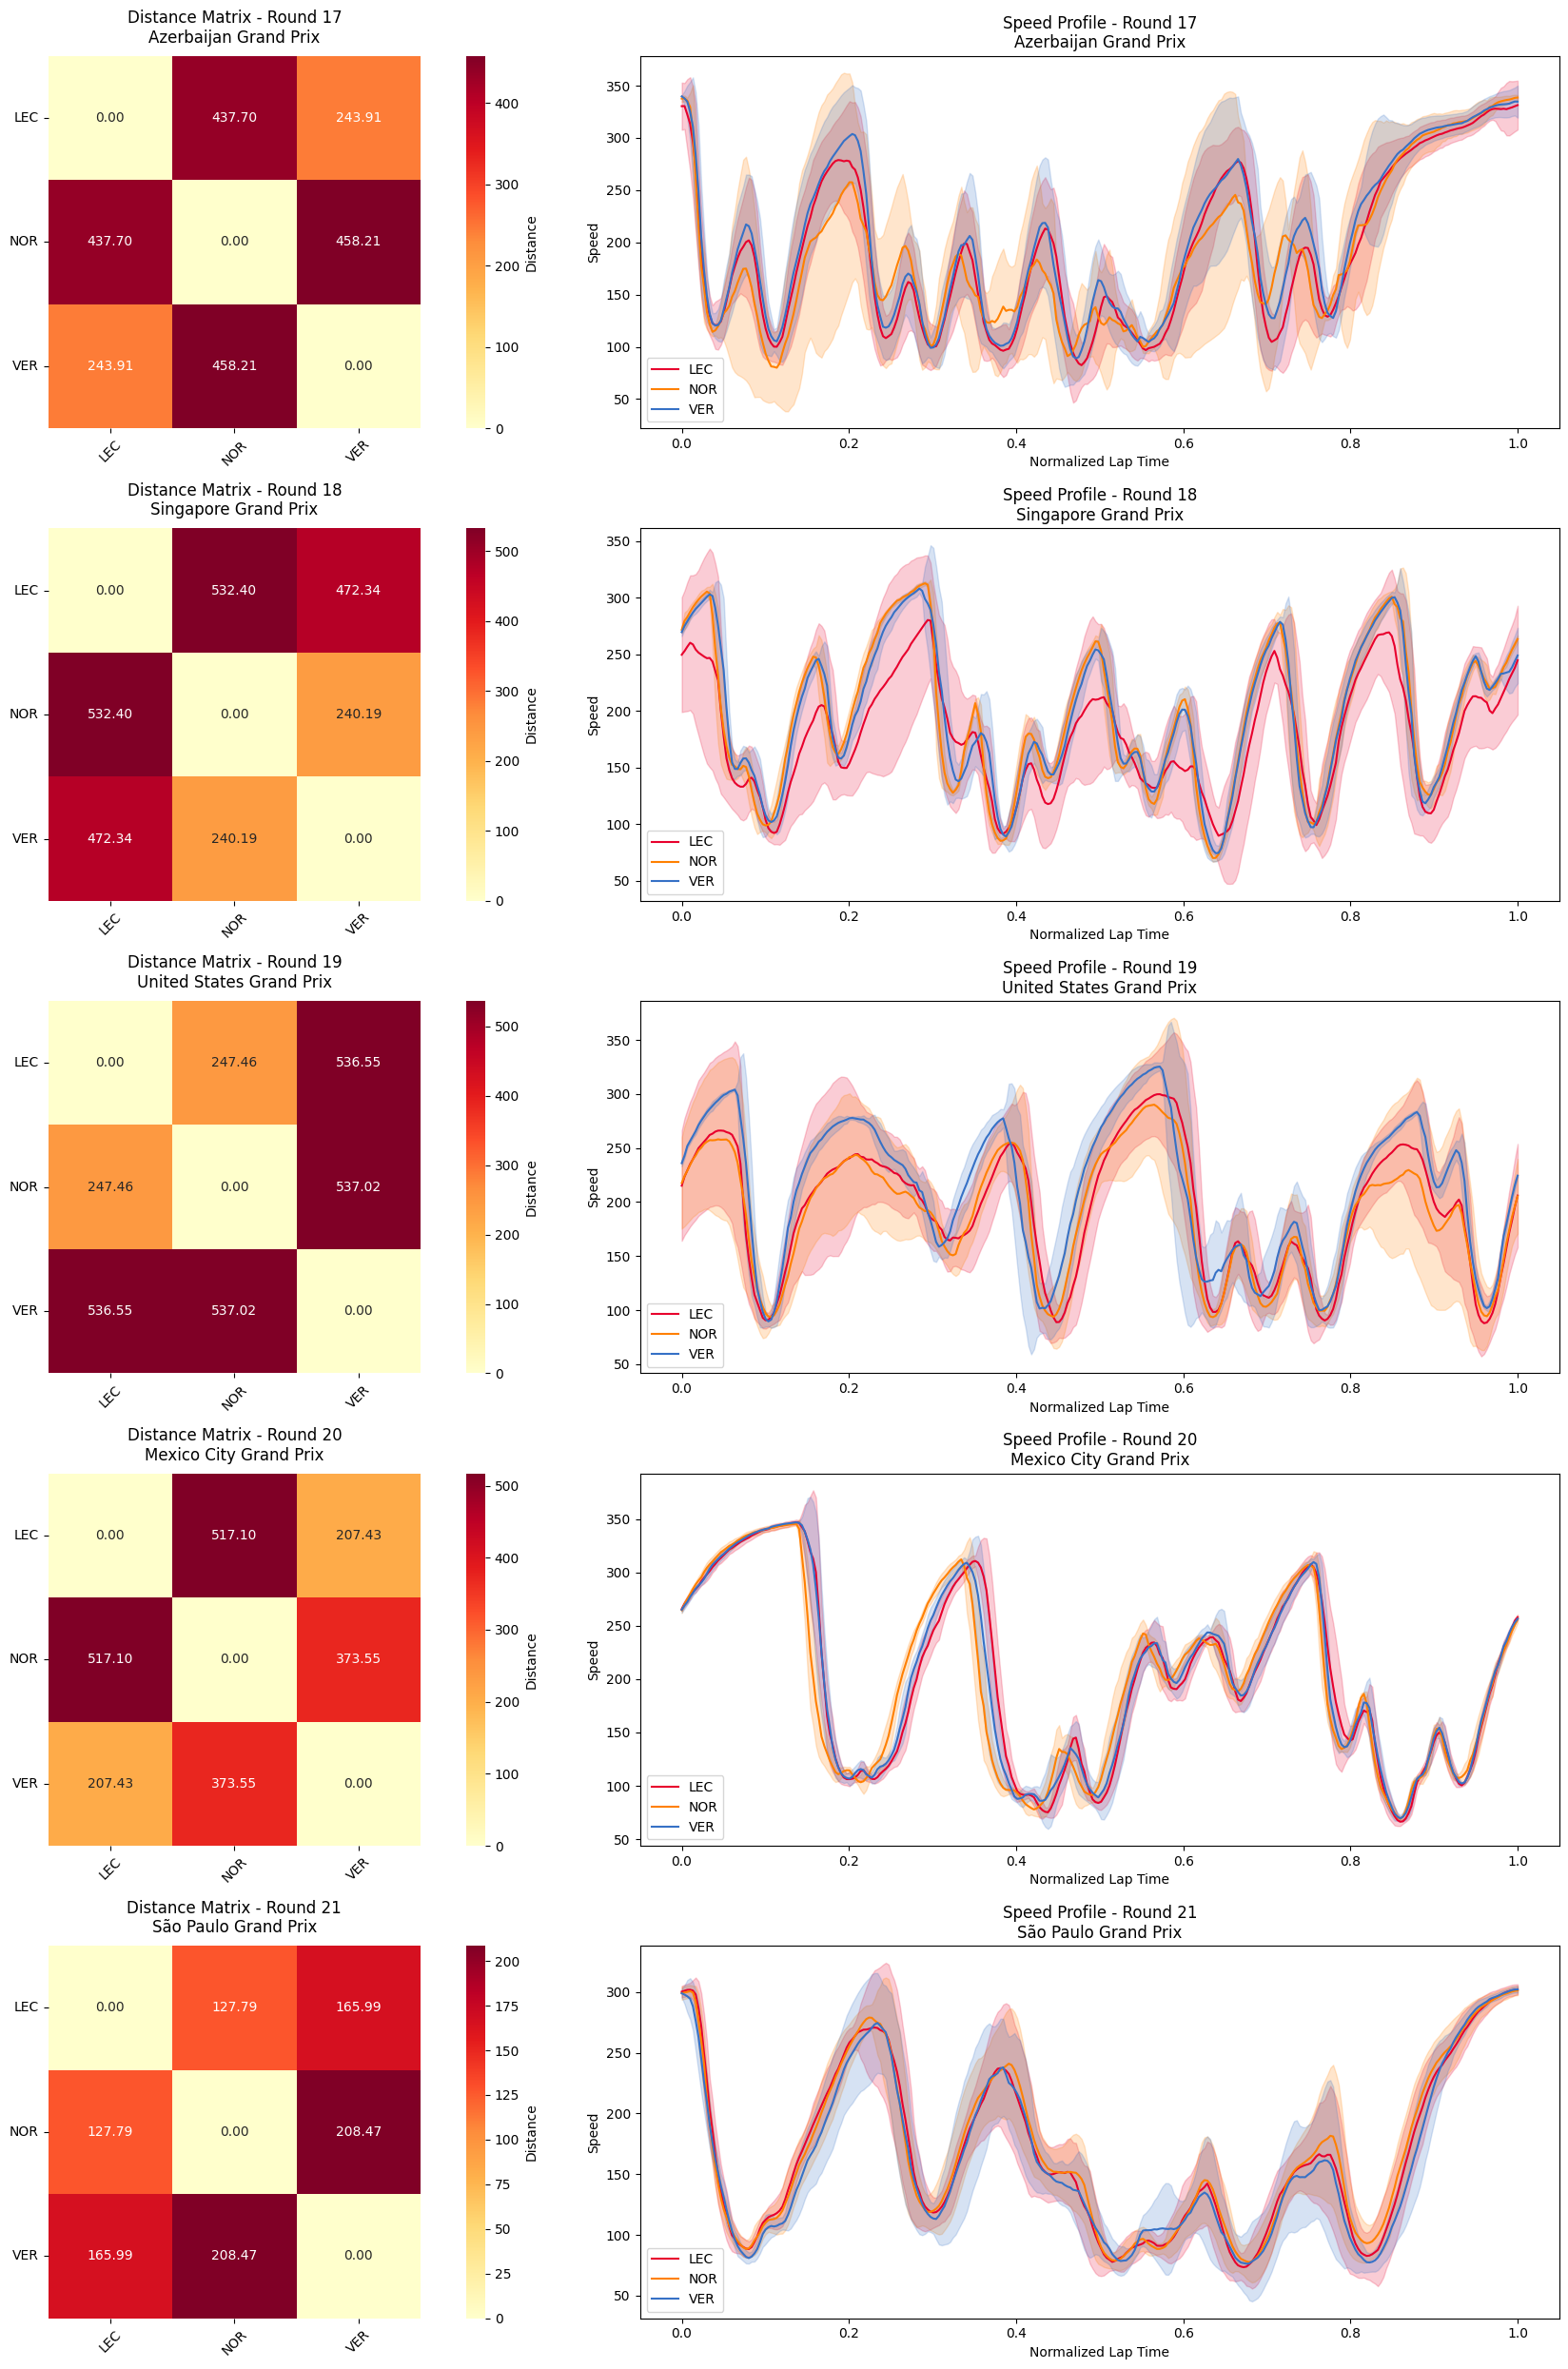

In [9]:
plot_combined_analysis(
    distance_matrices=distance_matrices,
    processed_laps=processed_laps,
    rounds=range(17, 22),
)

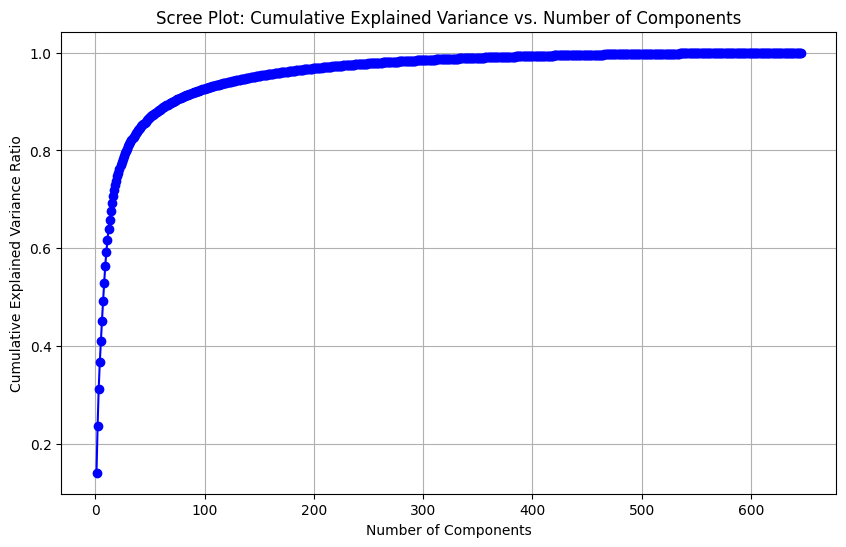

Number of components needed for 95.0% variance: 144


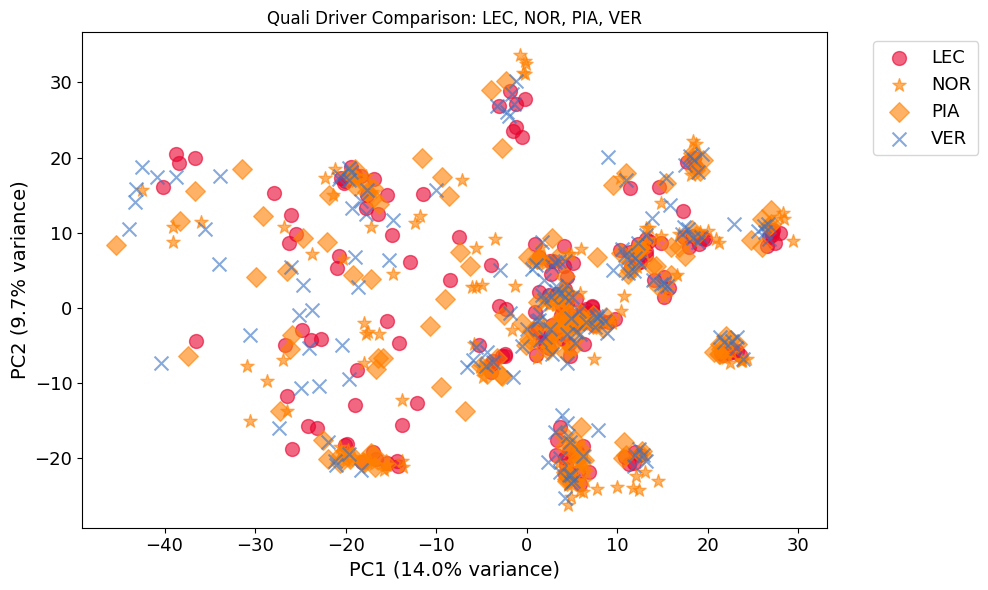

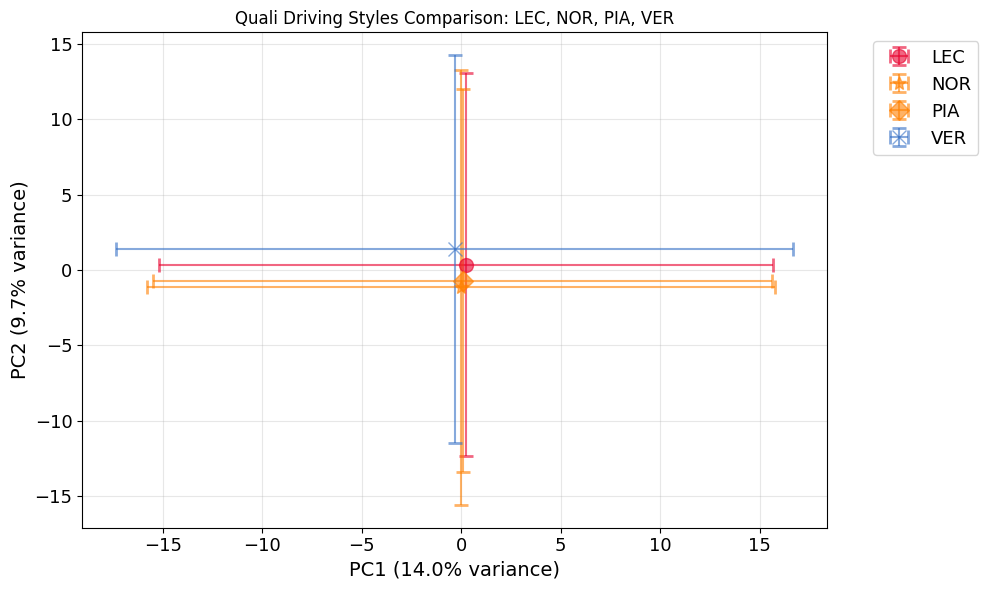


Driver Centroids (average position in PCA space):
             PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
Driver                                                                         
LEC     0.238409  0.368083  0.778883 -0.297056  0.066443 -0.467423  0.404660   
NOR    -0.006178 -1.150062 -0.632369 -0.067254  0.785646  0.872610 -0.108553   
PIA     0.069058 -0.693780 -0.059201  0.241666 -0.366630 -0.546509 -0.805082   
VER    -0.331138  1.418077 -0.192903  0.154229 -0.473817  0.221525  0.468185   

             PC8       PC9      PC10  ...     PC135     PC136     PC137  \
Driver                                ...                                 
LEC     0.054785  0.027698 -0.298376  ... -0.065760  0.034047  0.089411   
NOR     0.519121  0.887195  0.415142  ... -0.043783 -0.042501  0.031675   
PIA    -0.346731 -0.881478 -0.180515  ...  0.055098 -0.076888 -0.060520   
VER    -0.219469 -0.008585  0.110090  ...  0.060864  0.081389 -0.070010   

           PC138 

In [10]:
results = analyzer.analyze_laps(
    telemetry_data=quali_telemetry,
    rounds=range(1, 22),
    drivers=["LEC", "NOR", "PIA", "VER",],
    pca=True,
    session_type="Quali"
)

## Race Performance
Similar to qualifying sessions, we use two datasets here `race_data` and `race_telemetry`.

In [11]:
processor = F1DataProcessor(cache_dir="cache", year=2024)

race_data, race_telemetry = processor.get_race_session(
    rounds=range(1, 22),
    drivers=["VER", "NOR", "LEC", "PIA"],
    normalize_telemetry=True, 
    target_points=300
)

core        WARNING 	No lap data for driver 23
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 23)


In [12]:
race_data.head()

,Round,Driver,DriverNumber,Team,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,...,IsPersonalBest,Compound,TyreLife,FreshTyre,TrackStatus,Deleted,DeletedReason,LapStartDate,LapEndDate,Position
0,1,VER,1,Red Bull Racing,0 days 00:01:37.284000,1.0,1.0,NaN,41.266,23.616,...,False,SOFT,4.0,False,12,False,,2024-03-02 15:03:42.342,2024-03-02 15:05:19.626,1.0
1,1,VER,1,Red Bull Racing,0 days 00:01:36.296000,2.0,1.0,30.916,41.661,23.719,...,True,SOFT,5.0,False,1,False,,2024-03-02 15:05:19.941,2024-03-02 15:06:56.237,1.0
2,1,VER,1,Red Bull Racing,0 days 00:01:36.753000,3.0,1.0,30.999,41.966,23.788,...,False,SOFT,6.0,False,1,False,,2024-03-02 15:06:56.237,2024-03-02 15:08:32.990,1.0
3,1,VER,1,Red Bull Racing,0 days 00:01:36.647000,4.0,1.0,30.931,41.892,23.824,...,False,SOFT,7.0,False,1,False,,2024-03-02 15:08:32.990,2024-03-02 15:10:09.637,1.0
4,1,VER,1,Red Bull Racing,0 days 00:01:37.173000,5.0,1.0,31.255,42.056,23.862,...,False,SOFT,8.0,False,1,False,,2024-03-02 15:10:09.637,2024-03-02 15:11:46.810,1.0


In [13]:
race_telemetry.head()

,RPM,Speed,nGear,DRS,Throttle,Brake,CumulativeDistance,Time,LapNumber,Driver,Round
0,9963.000000,0.000000,1.0,1.0,15.000000,1.000000,0.000000,0 days 00:00:00.048000,1,VER,1
1,9464.230769,0.692308,1.0,1.0,15.000000,0.769231,0.046154,0 days 00:00:00.343384615,1,VER,1
2,7719.615385,6.692308,1.0,1.0,15.000000,0.000000,0.630769,0 days 00:00:00.638769231,1,VER,1
3,6039.615385,15.153846,1.0,1.0,15.000000,0.000000,2.302564,0 days 00:00:00.878769231,1,VER,1
4,3884.846154,29.000000,1.0,1.0,19.615385,0.000000,7.450427,0 days 00:00:01.296307692,1,VER,1


In [14]:
race_results = race_data[["Round", "Driver", "Position"]].drop_duplicates()
race_results = race_results.groupby(["Driver"]).agg({"Position": [("avg_finish_pos", "mean"), ("std_finish_pos", "std")]})
race_results.columns = race_results.columns.get_level_values(1)
race_results

,avg_finish_pos,std_finish_pos
Driver,,
LEC,4.761905,4.504495
NOR,4.095238,4.097618
PIA,4.904762,3.080662
VER,3.571429,4.032015


In [15]:
quali_results.columns = quali_results.columns.get_level_values(1)
quali_results

,avg_starting_pos,std_starting_pos,pole_count
Driver,,,
LEC,5.000000,2.949576,2
NOR,3.571429,3.370036,7
PIA,5.523810,3.458599,0
VER,2.809524,2.803909,9


In [16]:
gp_result = race_results.join(quali_results)
gp_result

,avg_finish_pos,std_finish_pos,avg_starting_pos,std_starting_pos,pole_count
Driver,,,,,
LEC,4.761905,4.504495,5.000000,2.949576,2
NOR,4.095238,4.097618,3.571429,3.370036,7
PIA,4.904762,3.080662,5.523810,3.458599,0
VER,3.571429,4.032015,2.809524,2.803909,9


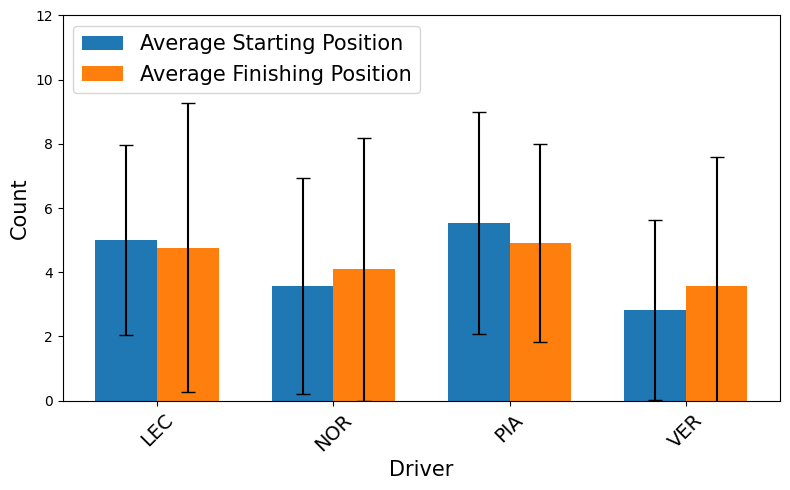

In [17]:
plt.figure(figsize=(8, 5))

x = range(len(quali_results.index))
width = 0.35

plt.bar([i - width/2 for i in x], gp_result["avg_starting_pos"], width, 
       yerr=gp_result["std_starting_pos"], 
       capsize=5,
       label="Average Starting Position")

plt.bar([i + width/2 for i in x], gp_result["avg_finish_pos"], width,
       yerr=gp_result["std_finish_pos"],
       capsize=5,
       label="Average Finishing Position")

plt.xlabel("Driver", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.ylim(0, 12)
# plt.title("2024 Qualifying Performance Comparison", fontsize=15)
plt.xticks(x, quali_results.index, rotation=45, fontsize=14)
plt.legend(loc="upper left", fontsize=15)
plt.tight_layout()
plt.savefig("imgs/2024 Qualifying vs Race Performance.png")
plt.show()

In [18]:
pole_count = quali_data[["Driver", "Round", "Position"]].drop_duplicates().rename(columns={"Position":"QualiResult"})
pole_count

,Driver,Round,QualiResult
18,LEC,1,2.0
118,PIA,1,8.0
103,NOR,1,7.0
1,VER,1,1.0
78,PIA,2,5.0
...,...,...,...
22,VER,20,2.0
1,NOR,21,1.0
154,LEC,21,6.0
211,PIA,21,8.0


In [19]:
finish_count = race_data[["Driver", "Round", "Position"]].drop_duplicates().rename(columns={"Position":"RaceResult"})
finish_count

,Driver,Round,RaceResult
0,VER,1,1.0
171,LEC,1,4.0
285,NOR,1,6.0
399,PIA,1,8.0
0,VER,2,1.0
...,...,...,...
497,PIA,20,8.0
0,VER,21,1.0
276,LEC,21,5.0
652,NOR,21,6.0


In [20]:
merged_df = pd.merge(finish_count, pole_count, on=["Driver", "Round"])

poles = merged_df[merged_df["QualiResult"] == 1].groupby("Driver").size()
wins = merged_df[merged_df["RaceResult"] == 1].groupby("Driver").size()
poles_and_wins = merged_df[(merged_df["QualiResult"] == 1) & (merged_df["RaceResult"] == 1)].groupby("Driver").size()

# Create a dataframe with all metrics
conversion_stats = pd.DataFrame({
   "pole_count": poles,
   "win_count": wins,
   "poles_converted": poles_and_wins,
   "conversion_rate": (poles_and_wins / poles * 100).round(2)
})

conversion_stats.dropna()

,pole_count,win_count,poles_converted,conversion_rate
Driver,,,,
LEC,2.0,3,1.0,50.00
NOR,7.0,3,2.0,28.57
VER,9.0,8,5.0,55.56


### Telemetry Analysis

In [21]:
race_telemetry

,RPM,Speed,nGear,DRS,Throttle,Brake,CumulativeDistance,Time,LapNumber,Driver,Round
0,9963.000000,0.000000,1.0,1.0,15.000000,1.000000,0.000000,0 days 00:00:00.048000,1,VER,1
1,9464.230769,0.692308,1.0,1.0,15.000000,0.769231,0.046154,0 days 00:00:00.343384615,1,VER,1
2,7719.615385,6.692308,1.0,1.0,15.000000,0.000000,0.630769,0 days 00:00:00.638769231,1,VER,1
3,6039.615385,15.153846,1.0,1.0,15.000000,0.000000,2.302564,0 days 00:00:00.878769231,1,VER,1
4,3884.846154,29.000000,1.0,1.0,19.615385,0.000000,7.450427,0 days 00:00:01.296307692,1,VER,1
...,...,...,...,...,...,...,...,...,...,...,...
295,10840.277592,310.000000,8.0,1.0,99.000000,0.000000,528145.792219,0 days 02:07:28.683424749,69,PIA,21
296,10841.431438,310.180602,8.0,1.0,99.000000,0.000000,531789.069583,0 days 02:07:28.924896321,69,PIA,21
297,10857.000000,311.000000,8.0,1.0,99.000000,0.000000,535445.326660,0 days 02:07:29.084775920,69,PIA,21
298,10855.735786,311.000000,8.0,1.0,99.000000,0.000000,539119.749963,0 days 02:07:29.309448161,69,PIA,21


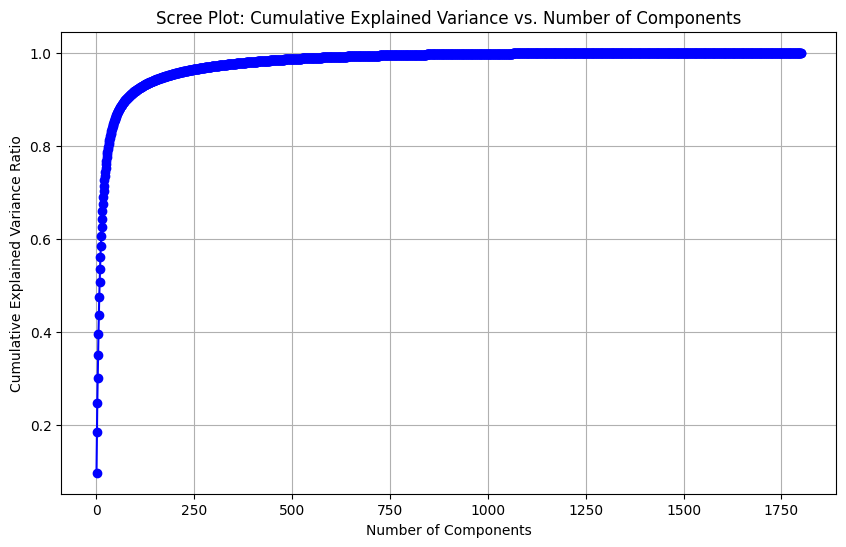

Number of components needed for 95.0% variance: 180


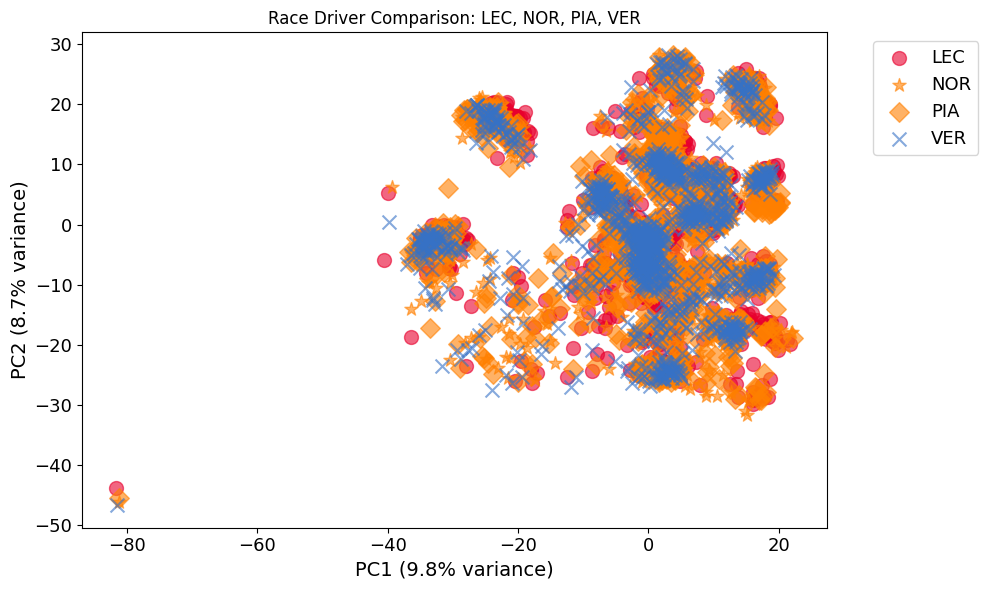

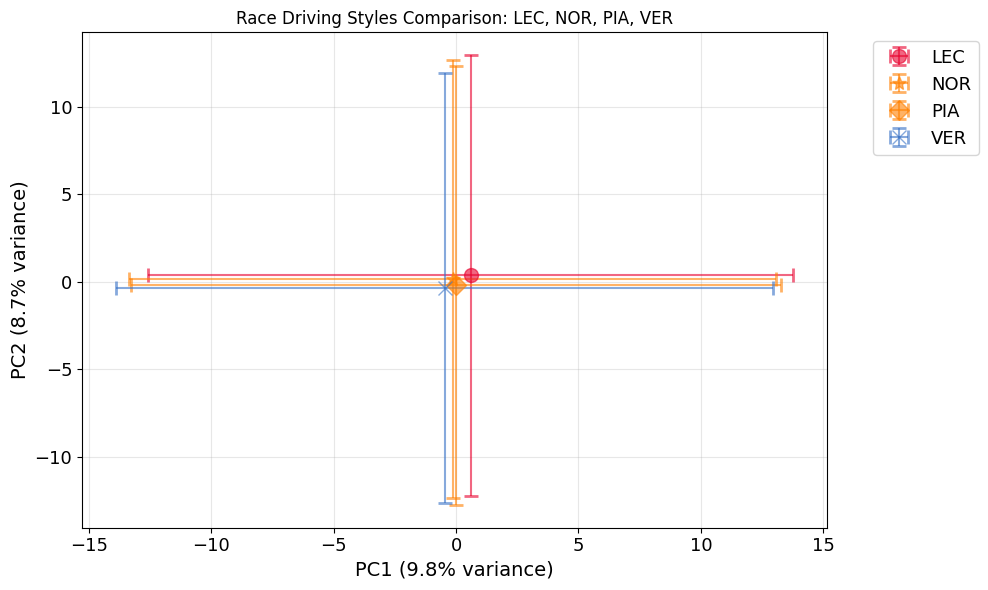


Driver Centroids (average position in PCA space):
             PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
Driver                                                                         
LEC     0.600710  0.377781  0.037031  0.322799  0.552461  0.055377  0.872296   
NOR    -0.136395  0.155961  0.062761  0.105188  0.018799  0.244695 -0.256086   
PIA    -0.000139 -0.200626 -0.256097  0.170954  0.561701 -0.013597  0.659825   
VER    -0.470838 -0.337716  0.165390 -0.618397 -1.172589 -0.297279 -1.315470   

             PC8       PC9      PC10  ...     PC171     PC172     PC173  \
Driver                                ...                                 
LEC     0.789024 -0.069985  0.360984  ...  0.042887  0.048469 -0.047415   
NOR    -0.038152  0.118285 -0.016331  ...  0.007705  0.034455 -0.023141   
PIA     0.053323 -0.095033  0.355254  ... -0.069181 -0.036497  0.037208   
VER    -0.821504  0.047828 -0.724020  ...  0.020753 -0.047101  0.033489   

           PC174 

In [22]:
analyzer = F1TelemetryAnalyzer(n_samples=300)

results = analyzer.analyze_laps(
   race_telemetry,
   rounds=range(1, 22),
   drivers=["LEC", "NOR", "PIA", "VER",],
   session_type="Race",
   pca=True,
)

processed_laps = results["processed_data"]
lap_metrics = results["lap_metrics"]
distance_matrices = results["distance_matrices"]

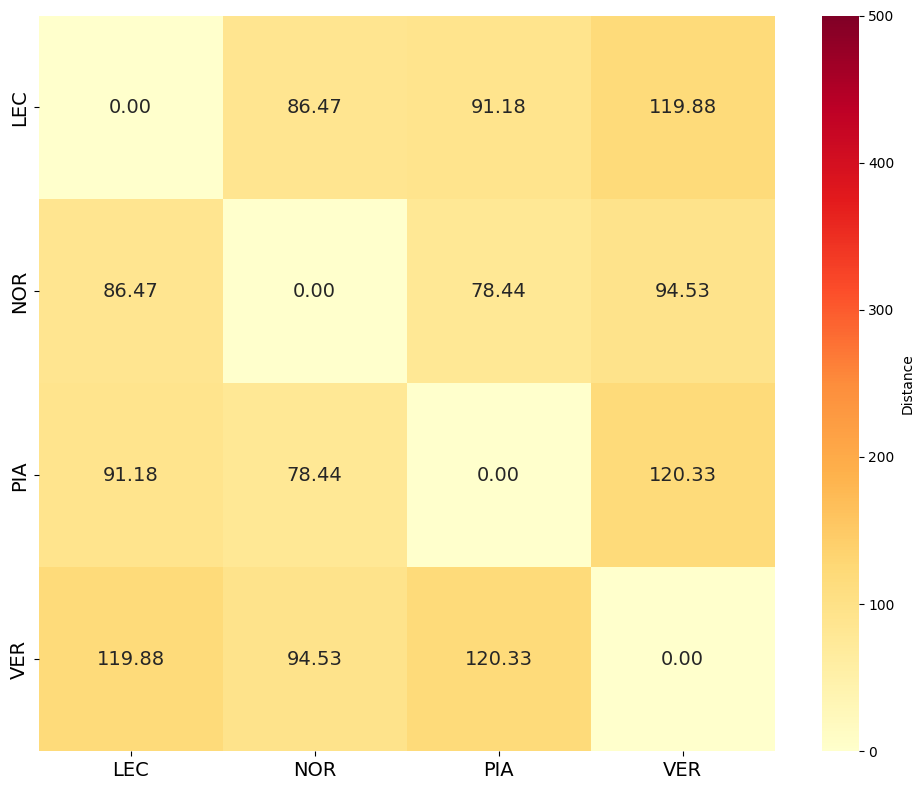

In [23]:
avg_matrix = np.mean(list(distance_matrices.values()), axis=0)

drivers = ["LEC", "NOR", "PIA", "VER"]
df = pd.DataFrame(avg_matrix, index=drivers, columns=drivers)

plt.figure(figsize=(10, 8))
sns.heatmap(df, 
            annot=True, 
            fmt=".2f",
            cmap="YlOrRd",
            square=True,
            annot_kws={'size': 14},
            cbar_kws={"label": "Distance"},
            vmin=0,
            vmax=500)

# plt.title("Average Qualifying Speed Distance Matrix")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("imgs/Average Race Speed Distance Matrix.png")
plt.show()

### Last 5 Races Comparison
We take the last 5 races of the 2024 season to compare as these races have seen all three drivers win and has been hailed as the races that have had the cars on almost level ground.<br>
The last 5 races are:
- Azerbaijan Grand Prix
- Singapore Grand Prix -> Norris won
- United States Grand Prix -> Leclerc won
- Mexico Grand Prix
- São Paulo Grand Prix -> Verstappen won

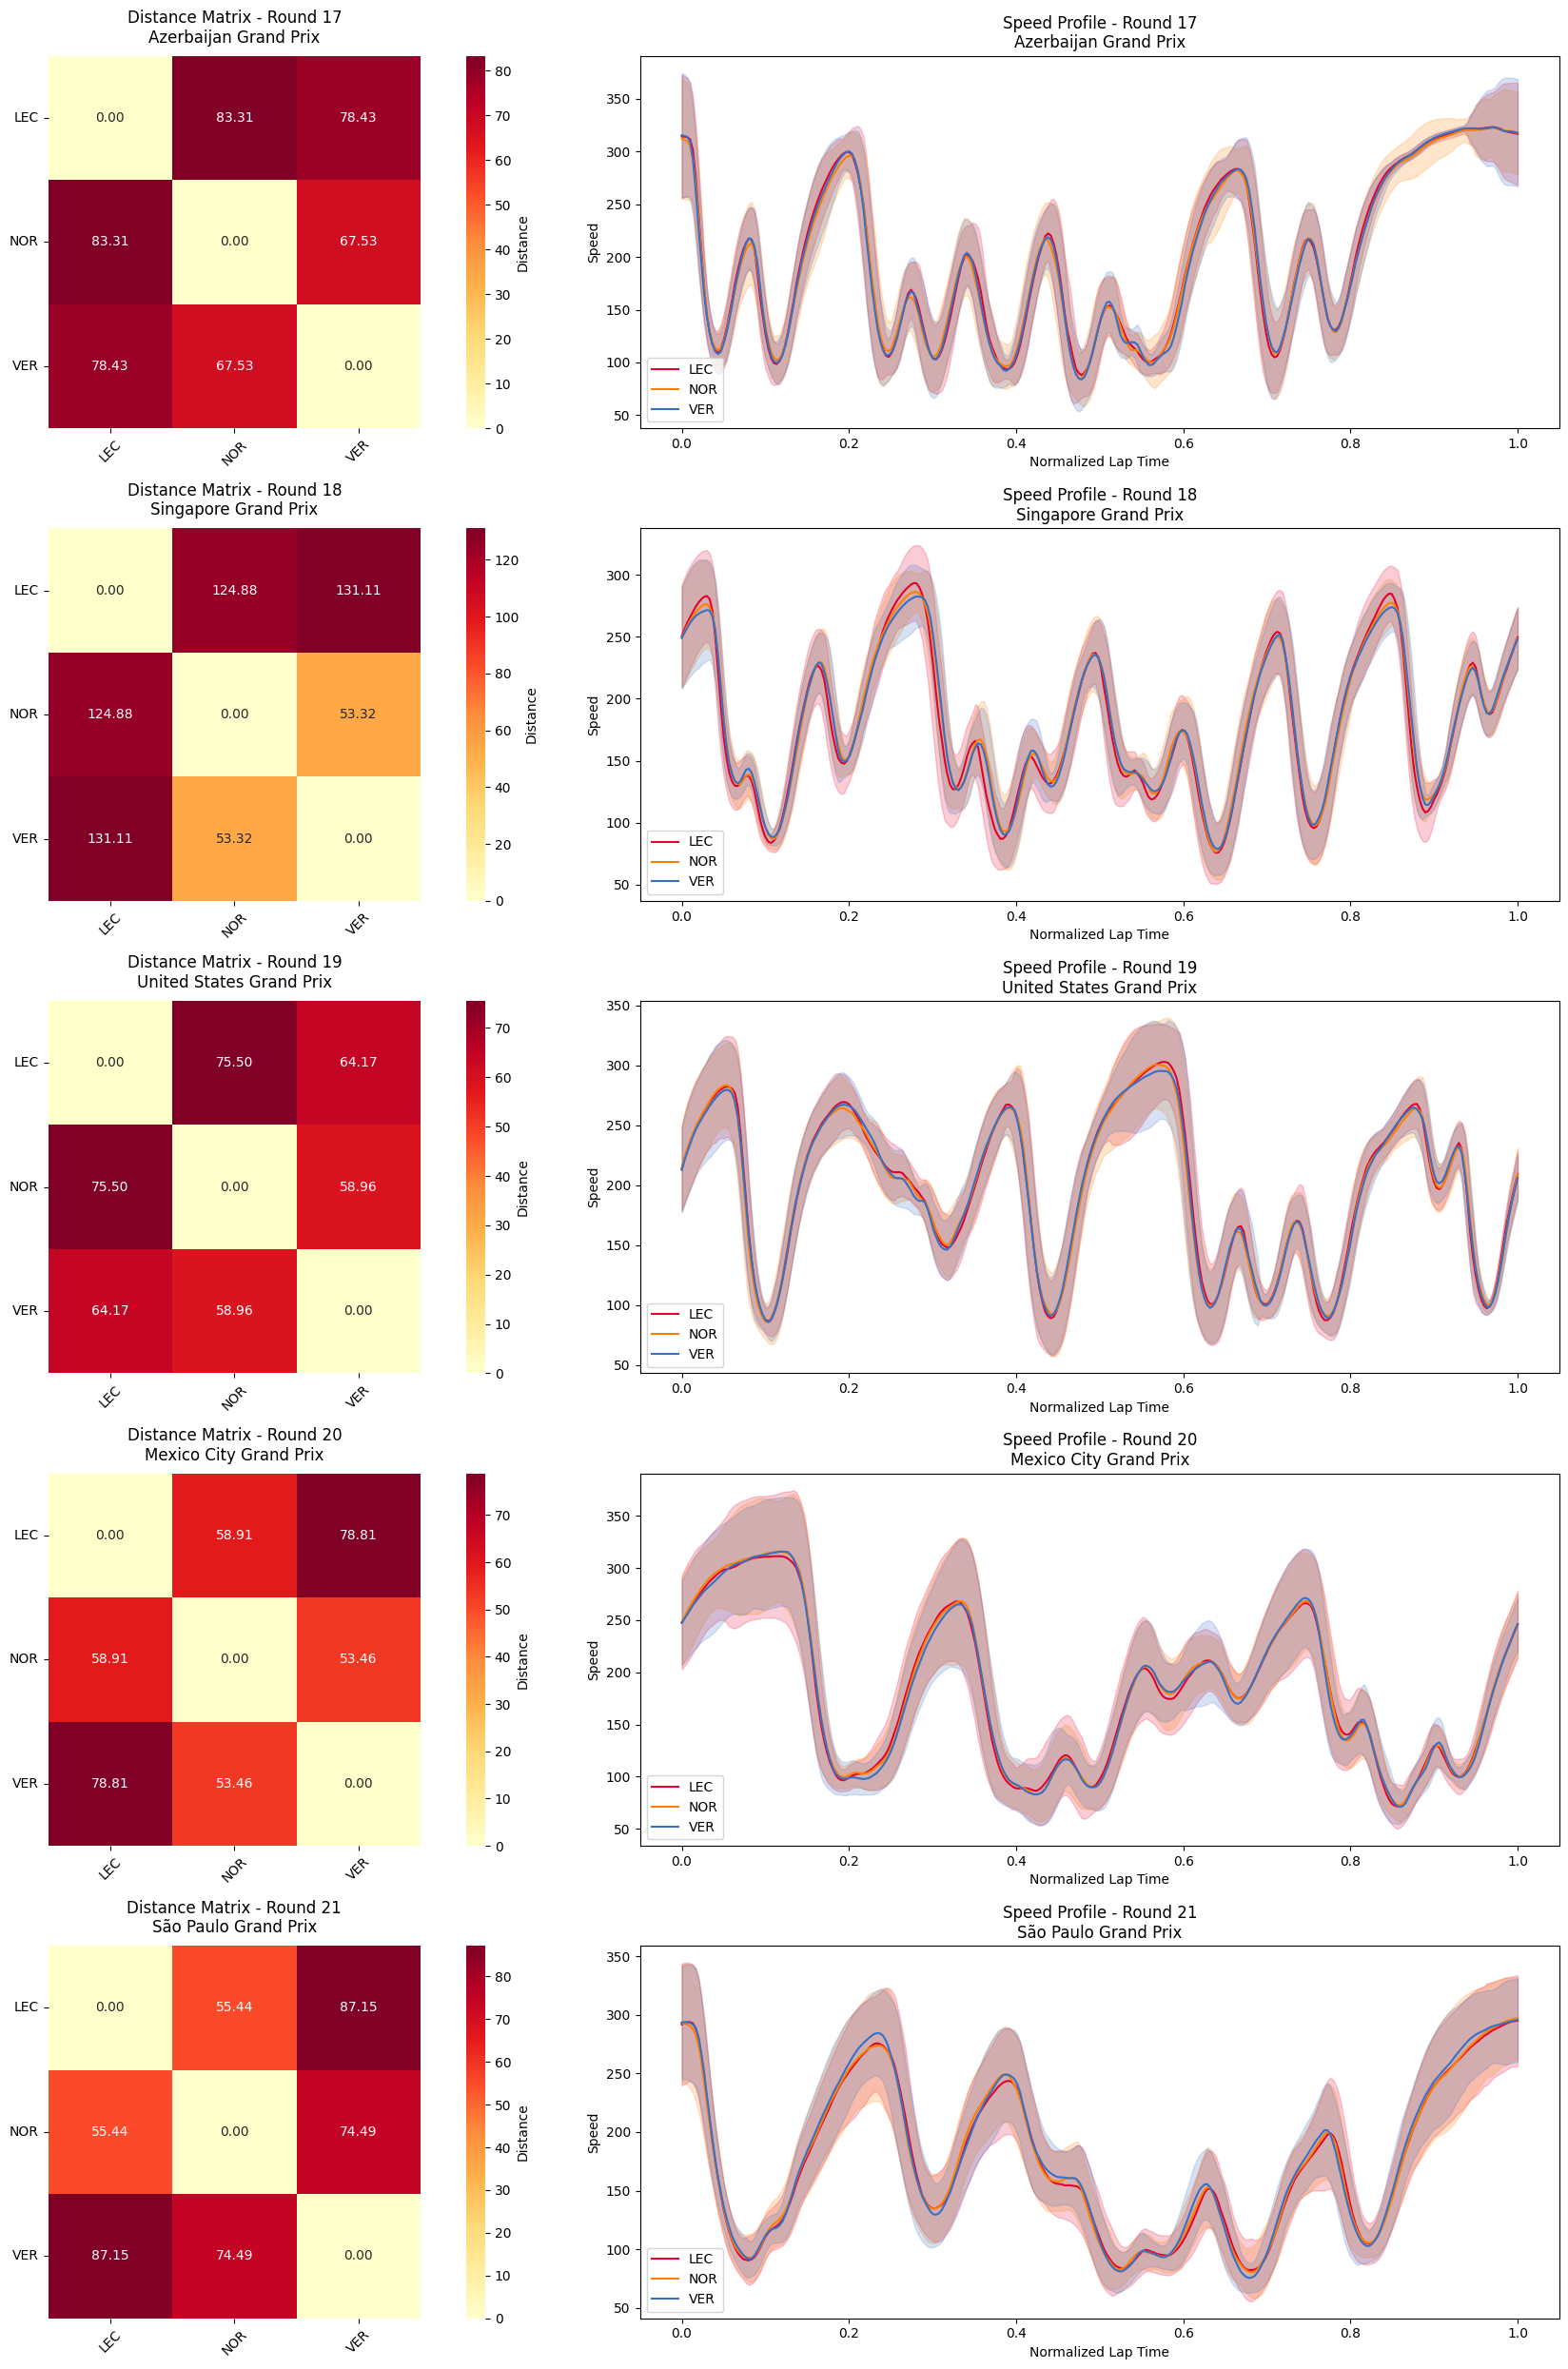

In [24]:
plot_combined_analysis(
    distance_matrices=distance_matrices,
    processed_laps=processed_laps,
    rounds=range(17, 22),
)

## Driver Performance Index

core        WARNING 	Driver  2: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver  3: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	No lap data for driver 2
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 2)


Number of components needed for 95.0% variance: 144

Driver Centroids (average position in PCA space):
             PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
Driver                                                                         
LEC     0.238409  0.368083  0.778883 -0.297056  0.066443 -0.467423  0.404660   
NOR    -0.006178 -1.150062 -0.632369 -0.067254  0.785646  0.872610 -0.108553   
PIA     0.069058 -0.693780 -0.059201  0.241666 -0.366630 -0.546509 -0.805082   
VER    -0.331138  1.418077 -0.192903  0.154229 -0.473817  0.221525  0.468185   

             PC8       PC9      PC10  ...     PC135     PC136     PC137  \
Driver                                ...                                 
LEC     0.054785  0.027698 -0.298376  ...  0.021365 -0.062920 -0.133243   
NOR     0.519121  0.887195  0.415142  ... -0.106437  0.040998 -0.054060   
PIA    -0.346731 -0.881478 -0.180515  ... -0.016256 -0.047227  0.179031   
VER    -0.219469 -0.008585  0.110090  ...

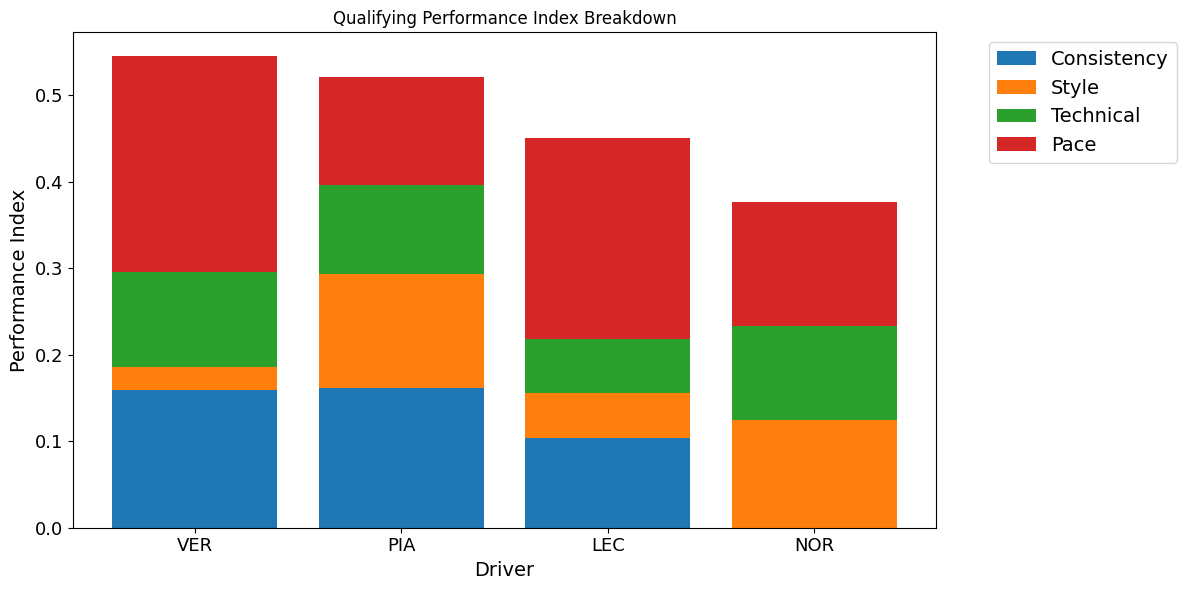

In [25]:
# Initialize the components
data_processor = F1DataProcessor(cache_dir="cache/", year=2024)
telemetry_analyzer = F1TelemetryAnalyzer(show_plots=False)

performance_analyzer = F1DriverPerformanceIndex(
    data_processor=data_processor,
    telemetry_analyzer=telemetry_analyzer,
    session_type="Qualifying"
)

performance_index = performance_analyzer.calculate_performance_index(
    rounds=range(1, 22),
    drivers=["LEC", "NOR", "PIA", "VER"]
)

perf_idx = performance_analyzer.plot_performance_breakdown(performance_index)

In [26]:
perf_idx

,Driver,Consistency,Style,Technical,Pace,PerformanceIndex
3,VER,0.637447,0.106317,0.438824,1.000000,0.545647
1,PIA,0.644414,0.530919,0.410579,0.500000,0.521478
0,LEC,0.415040,0.207003,0.250000,0.928571,0.450154
2,NOR,0.000000,0.500000,0.433638,0.571429,0.376267


core        WARNING 	No lap data for driver 23
core        WARNING 	Failed to perform lap accuracy check - all laps marked as inaccurate (driver 23)


Number of components needed for 95.0% variance: 180

Driver Centroids (average position in PCA space):
             PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
Driver                                                                         
LEC     0.600710  0.377781  0.037031  0.322799  0.552461  0.055377  0.872296   
NOR    -0.136395  0.155961  0.062761  0.105188  0.018799  0.244695 -0.256086   
PIA    -0.000139 -0.200626 -0.256097  0.170954  0.561701 -0.013597  0.659825   
VER    -0.470838 -0.337716  0.165390 -0.618397 -1.172589 -0.297279 -1.315470   

             PC8       PC9      PC10  ...     PC171     PC172     PC173  \
Driver                                ...                                 
LEC     0.789024 -0.069985  0.360984  ... -0.075096  0.026838  0.046045   
NOR    -0.038152  0.118285 -0.016331  ... -0.032966  0.008199 -0.015746   
PIA     0.053323 -0.095033  0.355254  ...  0.044425 -0.034915 -0.015212   
VER    -0.821504  0.047828 -0.724020  ...

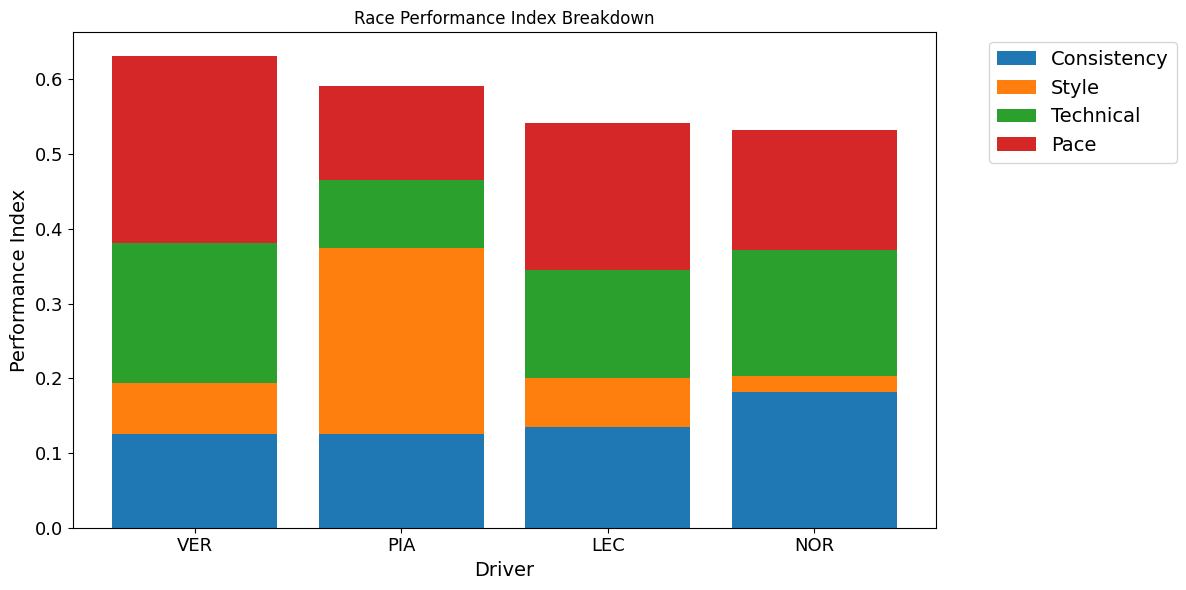

In [27]:
# Initialize the components
data_processor = F1DataProcessor(cache_dir="cache/", year=2024)
telemetry_analyzer = F1TelemetryAnalyzer(show_plots=False)

performance_analyzer = F1DriverPerformanceIndex(
    data_processor=data_processor,
    telemetry_analyzer=telemetry_analyzer,
    session_type="Race"
)

performance_index = performance_analyzer.calculate_performance_index(
    rounds=range(1, 22),
    drivers=["LEC", "NOR", "PIA", "VER"]
)

perf_idx = performance_analyzer.plot_performance_breakdown(performance_index)

In [28]:
perf_idx

,Driver,Consistency,Style,Technical,Pace,PerformanceIndex
0,VER,0.500000,0.276069,0.750000,1.000000,0.631517
3,PIA,0.500000,1.000000,0.363241,0.500000,0.590810
1,LEC,0.536615,0.264742,0.579575,0.785714,0.541662
2,NOR,0.724283,0.087377,0.677179,0.642857,0.532924
